In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from earlystop import EarlyStopper
from lstm_models import AirModel, StackLSTM, AirModel_DropOut, AirModelLayers


#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file7_080124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.134180,0.023473,0.002203,0.002203-0.001490j,0.002659,-0.594742,-0.051439
1,0.135824,0.025117,0.002051,0.002051+0.000170j,0.002058,0.082612,-0.020024
2,0.136482,0.025775,0.001900,0.001900+0.000303j,0.001924,0.158163,0.009547
3,0.137797,0.027090,0.001749,0.001749+0.000903j,0.001969,0.476669,0.035605
4,0.137797,0.027090,0.001599,0.001599+0.000993j,0.001882,0.555726,0.056848


### **data**

In [4]:
amplitudes = df['Amplitude'][300:30000].values
train, val = utils.split_data(amplitudes)
x_train, y_train = utils.create_dataset(train, 100)
x_val, y_val = utils.create_dataset(val, 100)
train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)

print(x_train.shape, y_train.shape ,x_val.shape, y_val.shape)

torch.Size([23660, 100, 1]) torch.Size([23660, 100, 1]) torch.Size([5840, 100, 1]) torch.Size([5840, 100, 1])


## **model**


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 7.1554827235792575e-06, Test Loss: 1.8609009566810036e-07
Epoch: 0, Loss: 3.9768110582372174e-07


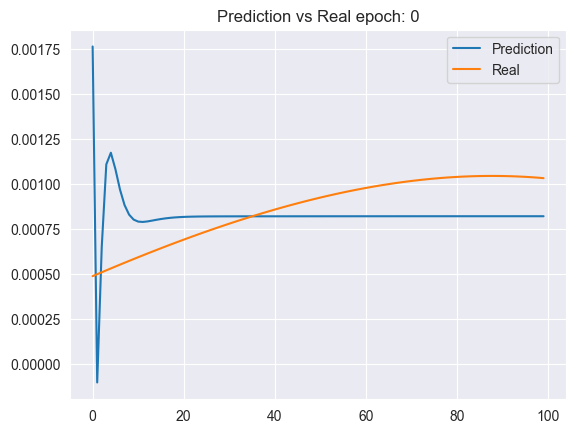

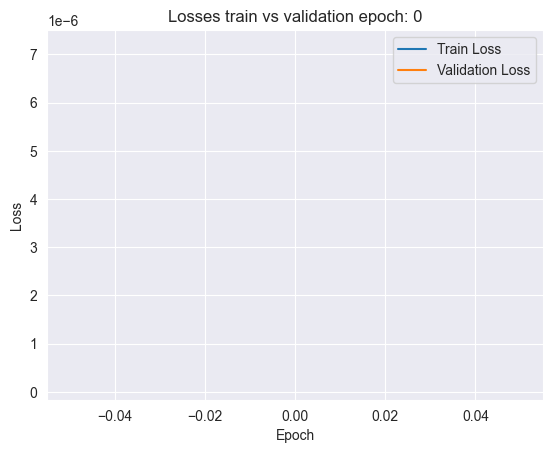

  1%|          | 1/100 [01:27<2:23:50, 87.17s/it]


Training interrupted by user


In [5]:
model = AirModelLayers(3, dropout = 0.25)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
n_epochs = 100
ncheckpoint = 10

m, av_train, av_val = utils.train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs, ncheckpoint)

In [49]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(av_train)), y=av_train, mode='lines', name='av_train'))
fig.add_trace(go.Scatter(x=np.arange(len(av_val)), y=av_val, mode='lines', name='av_val'))
fig.show()


In [10]:
np.argmin(av_train), np.argmin(av_val)

(408, 484)

## **testing**

In [5]:
fname = "file1_050124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,2.256644,0.049758,0.007786,0.007786-0.004629j,0.009058,-0.536394,-0.056599
1,2.258288,0.051402,0.007361,0.007361+0.000726j,0.007397,0.098350,-0.028915
2,2.260261,0.053375,0.006933,0.006933+0.001102j,0.007020,0.157607,-0.002832
3,2.260918,0.054033,0.006502,0.006502+0.003041j,0.007178,0.437517,0.020193
4,2.262233,0.055348,0.006068,0.006068+0.003316j,0.006915,0.500092,0.039028


In [37]:
amplitudes = df['Amplitude'][300:30000].values

train, val = utils.split_data(amplitudes)
val, test = utils.split_data(val, 0.5)

x_train, y_train = utils.create_dataset(train, 100)
x_val, y_val = utils.create_dataset(val, 100)
x_test, y_test = utils.create_dataset(test, 100)

train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)
test_loader = utils.create_loader(x_test, y_test, 32)

print(train_loader.dataset.tensors[0].shape, val_loader.dataset.tensors[0].shape, test_loader.dataset.tensors[0].shape)

torch.Size([23660, 100, 1]) torch.Size([2870, 100, 1]) torch.Size([2870, 100, 1])


In [39]:
model_trained = AirModel()
optimizer_trained = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [40]:
#cargo modelo
utils.resume(model_trained, optimizer_trained, 'checkpoint_450.pth')

In [35]:
x = utils.predictions(model_trained, val_loader)

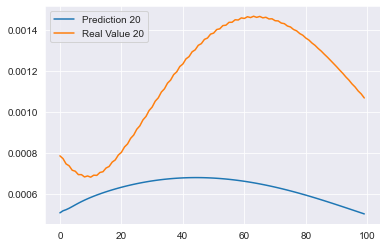

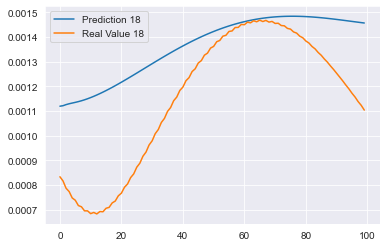

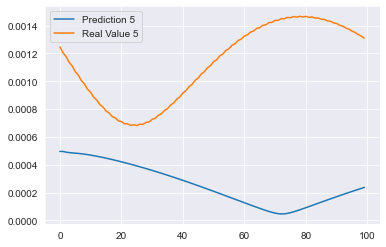

In [36]:
#x = utils.predictions(model_trained, val_loader) 
#Select 3 random indices
random_indices = np.random.choice(len(x), size=3, replace=False)

# Plot the selected predictions and real values
for i in random_indices:
    plt.figure()  # Create a new figure for each iteration
    plt.plot(np.arange(len(x[i])), x[i], label=f'Prediction {i}')
    plt.plot(np.arange(len(y_test[i])), y_test[i], label=f'Real Value {i}')
    plt.legend()
    plt.show()


## **second training**



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 2.851781469566646e-10, Test Loss: 3.029222510177022e-10
Epoch: 0, Loss: 3.0561825292707567e-10


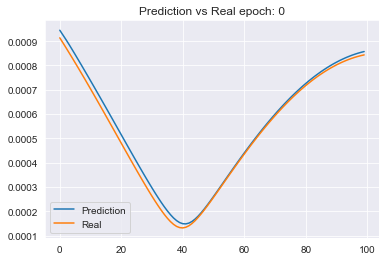

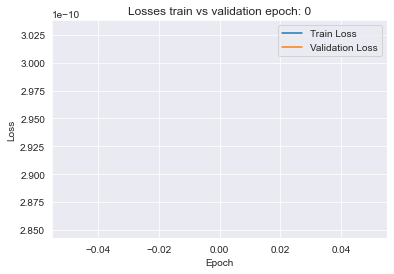

 10%|█         | 20/200 [06:10<54:44, 18.25s/it] 

Epoch: 20, Train Loss: 2.851427681059147e-10, Test Loss: 3.0284770493851614e-10
Epoch: 20, Loss: 2.637298990304515e-10


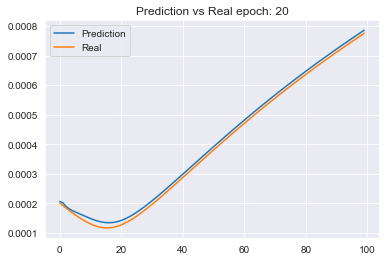

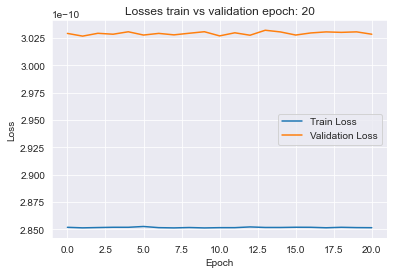

 20%|██        | 40/200 [12:16<49:11, 18.45s/it]

Epoch: 40, Train Loss: 2.851293280122821e-10, Test Loss: 3.0291998755051077e-10
Epoch: 40, Loss: 2.4781549035068906e-10


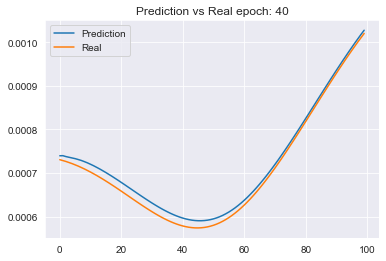

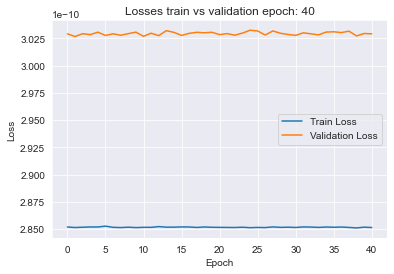

 30%|███       | 60/200 [18:21<41:31, 17.79s/it]

Epoch: 60, Train Loss: 2.8507736762433783e-10, Test Loss: 3.028835491056567e-10
Epoch: 60, Loss: 1.8629472964271088e-10


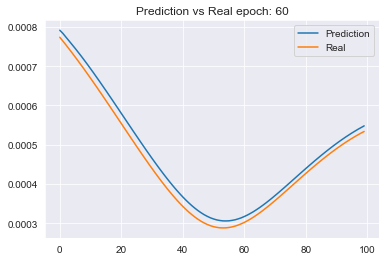

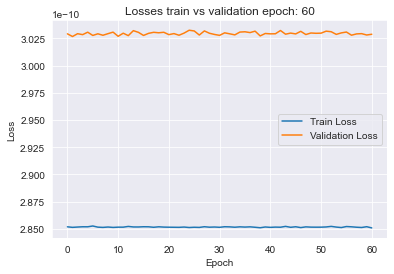

 40%|████      | 80/200 [24:12<35:03, 17.53s/it]

Epoch: 80, Train Loss: 2.851733973400487e-10, Test Loss: 3.028375127827548e-10
Epoch: 80, Loss: 2.999936687952953e-10


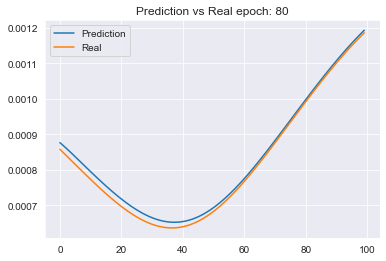

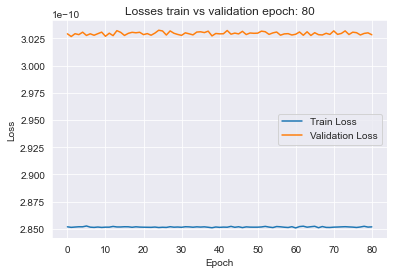

 50%|█████     | 100/200 [30:03<29:08, 17.49s/it]

Epoch: 100, Train Loss: 2.8516141981522087e-10, Test Loss: 3.028380358211575e-10
Epoch: 100, Loss: 2.8581448319187075e-10


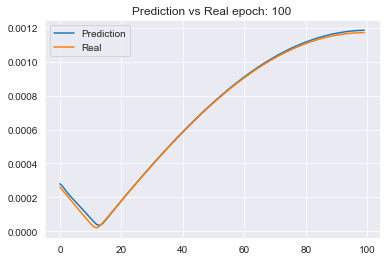

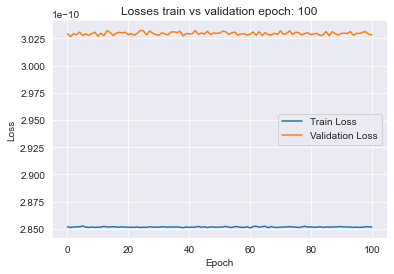

 60%|██████    | 120/200 [36:01<23:58, 17.98s/it]

Epoch: 120, Train Loss: 2.851272834765702e-10, Test Loss: 3.0294645280025554e-10
Epoch: 120, Loss: 2.453954817127624e-10


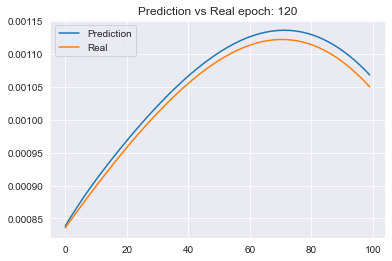

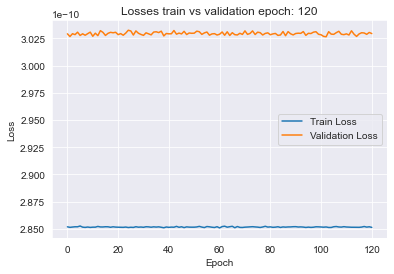

 70%|███████   | 140/200 [42:05<18:16, 18.27s/it]

Epoch: 140, Train Loss: 2.851964694810932e-10, Test Loss: 3.0294582891659477e-10
Epoch: 140, Loss: 3.273119553171e-10


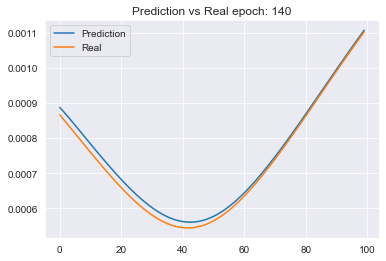

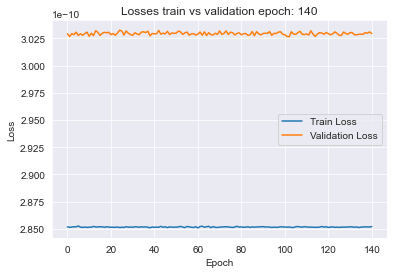

 80%|████████  | 160/200 [48:10<12:04, 18.12s/it]

Epoch: 160, Train Loss: 2.8516893116787185e-10, Test Loss: 3.0276543001090456e-10
Epoch: 160, Loss: 2.947060651070643e-10


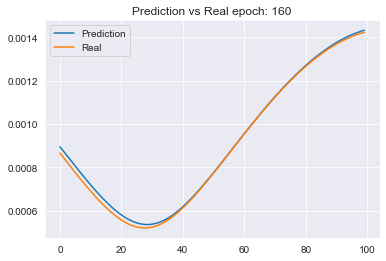

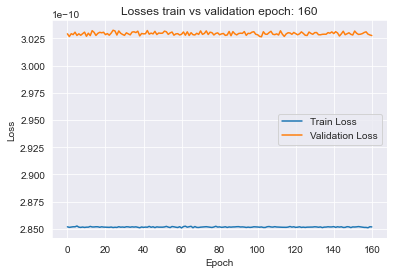

 90%|█████████ | 180/200 [54:13<05:57, 17.90s/it]

Epoch: 180, Train Loss: 2.8519827996978914e-10, Test Loss: 3.029996659440235e-10
Epoch: 180, Loss: 3.2945629557801226e-10


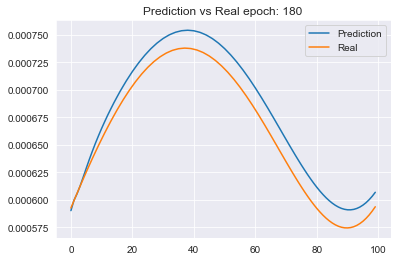

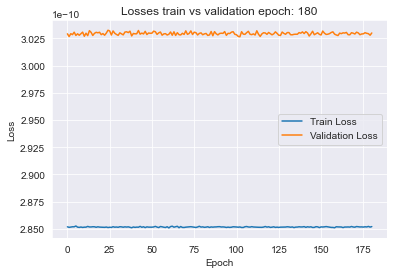

100%|██████████| 200/200 [1:00:30<00:00, 18.15s/it]


In [41]:
n_epochs = 200
ncheckpoint = 20

m2, av_train, av_val = utils.train_model(model_trained, optimizer_trained, criterion, train_loader, val_loader, n_epochs, ncheckpoint)

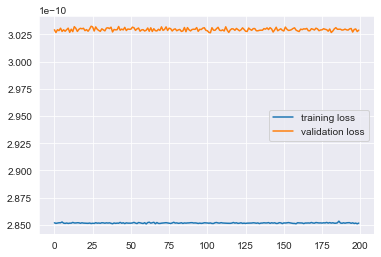

In [42]:
plt.plot(av_train, label='training loss')
plt.plot(av_val, label='validation loss')
plt.legend()
plt.show()

## **load and test model**

In [43]:
model_trained2 = AirModel()
optimizer_trained2 = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#cargo modelo
utils.resume(model_trained2, optimizer_trained2, 'checkpoint_160.pth')

In [44]:
x = utils.predictions(model_trained2, test_loader)

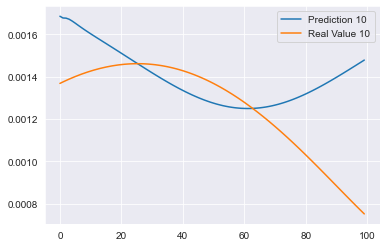

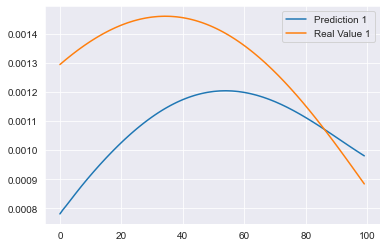

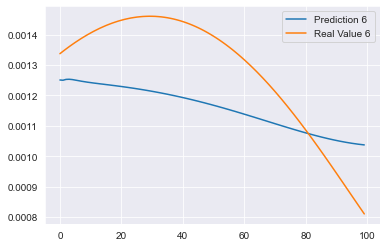

In [46]:
#Select 3 random indices
random_indices = np.random.choice(len(x), size=3, replace=False)

# Plot the selected predictions and real values
for i in random_indices:
    plt.figure()  # Create a new figure for each iteration
    plt.plot(np.arange(len(x[i])), x[i], label=f'Prediction {i}')
    plt.plot(np.arange(len(y_test[i])), y_test[i], label=f'Real Value {i}')
    plt.legend()
    plt.show()